In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

#Custom function to show open cv image on notebook.
def display_img(cvImg):
    cvImg = cv2.cvtColor(cvImg, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,8))
    plt.imshow(cvImg)
    plt.axis('off')
    plt.show()

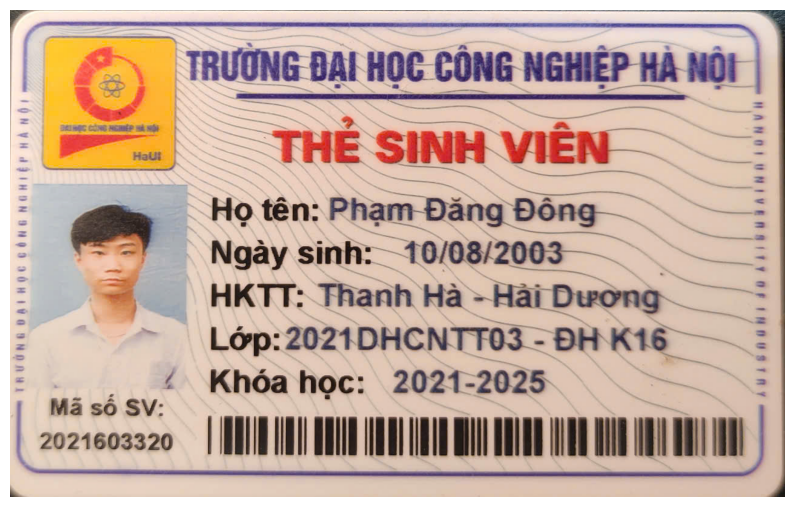

In [5]:
#Loading image using cv2
baseImg = cv2.imread('/home/anodi108/Desktop/project/Do_An_Tot_Nghiep/DATN_LuThiSen/resource/data/base_card.jpg')

#Declare image size, width height and chanel
baseH, baseW, baseC = baseImg.shape

display_img(baseImg)

# Detect cccd


0: 640x480 1 card, 65.6ms
Speed: 4.6ms preprocess, 65.6ms inference, 103.3ms postprocess per image at shape (1, 3, 640, 480)
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.], device='cuda:0')
conf: tensor([0.9075], device='cuda:0')
data: tensor([[1.6658e+02, 6.1793e+02, 1.3909e+03, 1.3927e+03, 9.0749e-01, 0.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (2048, 1536)
shape: torch.Size([1, 6])
xywh: tensor([[ 778.7386, 1005.3000, 1224.3203,  774.7344]], device='cuda:0')
xywhn: tensor([[0.5070, 0.4909, 0.7971, 0.3783]], device='cuda:0')
xyxy: tensor([[ 166.5785,  617.9329, 1390.8988, 1392.6672]], device='cuda:0')
xyxyn: tensor([[0.1084, 0.3017, 0.9055, 0.6800]], device='cuda:0')
<class 'numpy.ndarray'>
(775, 1224, 3)
[     166.58      617.93      1390.9      1392.7]


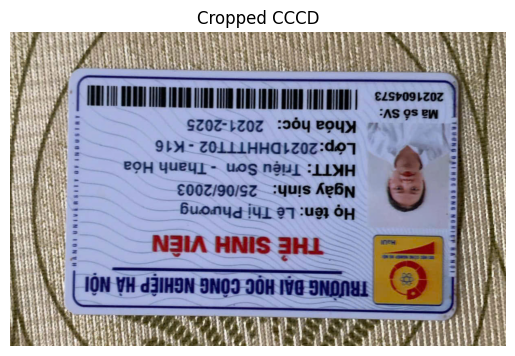

True

In [6]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Load mô hình YOLOv8 đã huấn luyện
model = YOLO('/home/anodi108/Desktop/project/Do_An_Tot_Nghiep/DATN_LuThiSen/resource/weights/last_detect_card_1004202510042025.pt')

# Đọc ảnh
image_path = '/home/anodi108/Desktop/project/Do_An_Tot_Nghiep/DATN_LuThiSen/resource/data/demo_data_card/LeThiPhuong1.jpg'
image = cv2.imread(image_path)
img2 = None

# Detect object
results = model(image)
print(results[0].boxes)

for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # Lấy tọa độ bounding box

        # Crop ảnh CCCD
        img2 = image[y1:y2, x1:x2]
        bbox = box.xyxy[0].cpu().numpy()
        print(type(img2))
        print(img2.shape)
        print(bbox)
        # Lưu ảnh đã crop
        cv2.imwrite("card_crop.jpg", img2)

        # Hiển thị ảnh crop bằng Matplotlib
        plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
        plt.title("Cropped CCCD")
        plt.axis("off")
        plt.show()

# Lưu ảnh có bounding box
cv2.imwrite("output_detect.jpg", img2)


# Preprocess image

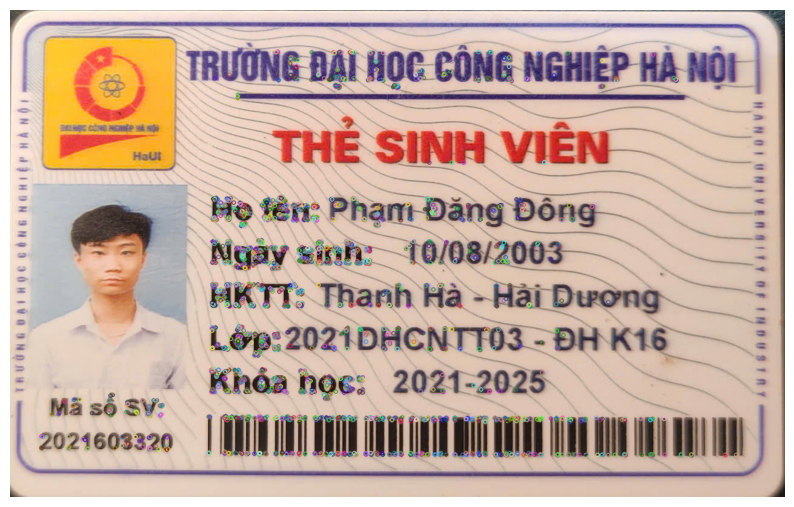

In [7]:
#Init orb, keypoints detection on base Image
orb = cv2.ORB_create(3000)

kp, des = orb.detectAndCompute(baseImg, None)
imgKp = cv2.drawKeypoints(baseImg,kp, None)

display_img(imgKp)

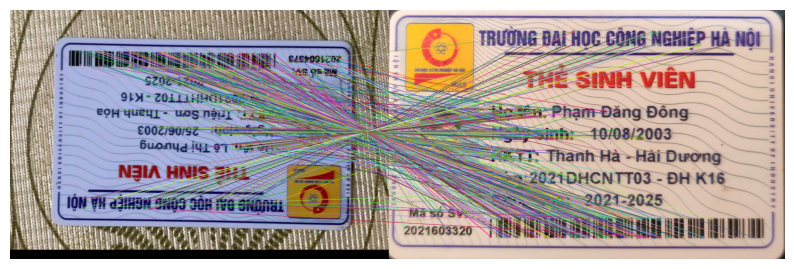

In [8]:
PER_MATCH = 0.25

#Detect keypoint on img2
kp1, des1 = orb.detectAndCompute(img2, None)

#Init BF Matcher, find the matches points of two images
bf = cv2.BFMatcher(cv2.NORM_HAMMING)
matches = list(bf.match(des1, des))

#Select top 30% best matcher 
matches.sort(key=lambda x: x.distance)
best_matches = matches[:int(len(matches)*PER_MATCH)]

#Show match img  
imgMatch = cv2.drawMatches(img2, kp1, baseImg, kp, best_matches,None, flags=2)
display_img(imgMatch)

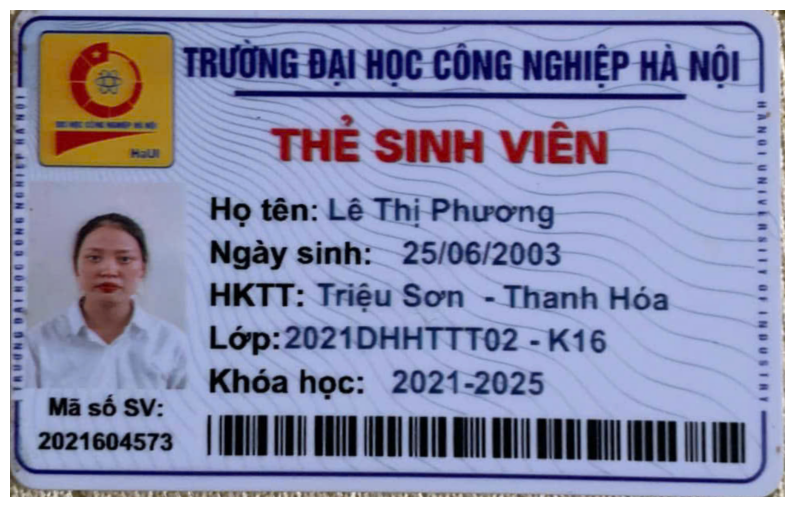

In [9]:
#Init source points and destination points for findHomography function.
srcPoints = np.float32([kp1[m.queryIdx].pt for m in best_matches]).reshape(-1,1,2)
dstPoints = np.float32([kp[m.trainIdx].pt for m in best_matches]).reshape(-1,1,2)


#Find Homography of two images
matrix_relationship, _ = cv2.findHomography(srcPoints, dstPoints,cv2.RANSAC, 5.0)

#Transform the image to have the same structure as the base image
img_final = cv2.warpPerspective(img2, matrix_relationship, (baseW, baseH))

display_img(img_final)

# Text detect

In [10]:
# prepare data

# Thư mục chứa ảnh đầu vào
input_folder = "/home/anodi108/Desktop/project/Do_An_Tot_Nghiep/DATN_LuThiSen/resource/data/demo_data_card"

# Thư mục chứa ảnh đầu ra (tạo nếu chưa có)
output_folder = "/home/anodi108/Desktop/project/Do_An_Tot_Nghiep/DATN_LuThiSen/resource/data/output_card"
os.makedirs(output_folder, exist_ok=True)

# Load mô hình YOLO đã huấn luyện
model = YOLO("/home/anodi108/Desktop/project/Do_An_Tot_Nghiep/DATN_LuThiSen/resource/weights/last_detect_card_1004202510042025.pt")

# Lấy danh sách file ảnh trong thư mục input
image_files = [f for f in os.listdir(input_folder) if f.endswith((".jpg", ".png", ".jpeg"))]
print(image_files)
# Đếm số lượng ảnh đã lưu
count = 1

for image_name in image_files:
    image_path = os.path.join(input_folder, image_name)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Lỗi khi đọc ảnh: {image_name}")
        continue

    # Detect CCCD
    results = model(image)

    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Lấy tọa độ bounding box
            bbox = box.xyxy[0].cpu().numpy()
            print(bbox)
            # Cắt ảnh CCCD từ ảnh gốc
            cropped_img = image[y1:y2, x1:x2]

            # Lưu ảnh đã cắt vào thư mục output
            output_path = os.path.join(output_folder, f"cccd_{count}.jpg")
            cv2.imwrite(output_path, cropped_img)
            print(f"Lưu ảnh: {output_path}")
            count += 1  # Tăng số thứ tự ảnh



['NguyenMinhHieu2.jpg', 'LeThiPhuong1.jpg', 'NguyenTrangNhung2.jpg', 'NguyenTrangNhung3.jpg', 'NguyenTrongTuan2.jpg', 'LuThiSen1.jpg', 'TranMinhTuan1.jpg', 'DuongVanDung1.jpg', 'TranMinhTuan2.jpg', 'NguyenThiHuyenTrang2.jpg', 'NguyenQuyetThang2.jpg', 'NguyenThiHuyenTrang3.jpg', 'NguyenTrongTuan1.jpg', 'NguyenTrongTuan4.jpg', 'NguyenMinhHieu1.jpg', 'NguyenThiHuyenTrang4.jpg', 'LuongBaHoang2.jpg', 'LuThiSen4.jpg', 'TrinhGiaLoc3.jpg', 'NguyenThiHuyenTrang1.jpg', 'NguyenMinhHieu3.jpg', 'NguyenTrongTuan3.jpg', 'NguyenTrangNhung1.jpg', 'TrinhGiaLoc1.jpg', 'NguyenQuyetThang1.jpg', 'NguyenQuyetThang3.jpg', 'LeThiPhuong4.jpg', 'PhamQuyQuoc3.jpg', 'DuongVanDung3.jpg', 'LuThihSen3.jpg', 'TranMinhTuan4.jpg', 'NguyenDinhLinh1.jpg', 'NguyenQuyetThang4.jpg', 'DuongVanDung2.jpg', 'LeThiPhuong3.jpg', 'LuThiSen2.jpg', 'LuongBaHoang1.jpg', 'PhamQuyQuoc4.jpg', 'TrinhGiaLoc2.jpg', 'NguyenDinhLinh3.jpg', 'PhamQuyQuoc1.jpg', 'LeThiPhuong2.jpg', 'LuongBaHoang3.jpg', 'PhamQuyQuoc2.jpg', 'NguyenDinhLinh2.jpg', 

In [11]:
import cv2
import os
import glob
def transform(img):
    #Init orb, keypoints detection on base Image
    orb = cv2.ORB_create(1000)
    kp, des = orb.detectAndCompute(baseImg, None)
    PER_MATCH = 0.25

    #Detect keypoint on img
    kp1, des1 = orb.detectAndCompute(img, None)

    #Init BF Matcher, find the matches points of two images
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = list(bf.match(des1, des))

    #Select top 30% best matcher 
    matches.sort(key=lambda x: x.distance)
    best_matches = matches[:int(len(matches)*PER_MATCH)]
    
    #Init source points and destination points for findHomography function.
    srcPoints = np.float32([kp1[m.queryIdx].pt for m in best_matches]).reshape(-1,1,2)
    dstPoints = np.float32([kp[m.trainIdx].pt for m in best_matches]).reshape(-1,1,2)


    #Find Homography of two images
    matrix_relationship, _ = cv2.findHomography(srcPoints, dstPoints,cv2.RANSAC, 5.0)

    #Transform the image to have the same structure as the base image
    img_final = cv2.warpPerspective(img, matrix_relationship, (baseW, baseH))

    return img_final

    
# Thư mục nguồn và đích
source_folder = "/home/anodi108/Desktop/project/Do_An_Tot_Nghiep/DATN_LuThiSen/resource/data/output_card"  # Thay bằng đường dẫn thư mục chứa ảnh gốc
destination_folder = "/home/anodi108/Desktop/project/Do_An_Tot_Nghiep/DATN_LuThiSen/resource/data/output_card_rotated"  # Thay bằng đường dẫn thư mục đích

# Tạo thư mục đích nếu chưa có
os.makedirs(destination_folder, exist_ok=True)

image_paths = sorted(glob.glob(os.path.join(source_folder, "*.*")), key=os.path.basename)

# Duyệt qua từng ảnh
for idx, image_path in enumerate(image_paths, start=1):
    # Đọc ảnh
    img = cv2.imread(image_path)
    
    # Tạo tên file mới theo thứ tự
    new_filename = os.path.join(destination_folder, f"{idx:04d}.png")  # 0001.png, 0002.png,...
    
    # Ghi ảnh vào thư mục đích
    cv2.imwrite(new_filename, transform(img))
    print(f"Đã lưu: {new_filename}")

print("Hoàn thành xử lý ảnh!")


Đã lưu: /home/anodi108/Desktop/project/Do_An_Tot_Nghiep/DATN_LuThiSen/resource/data/output_card_rotated/0001.png
Đã lưu: /home/anodi108/Desktop/project/Do_An_Tot_Nghiep/DATN_LuThiSen/resource/data/output_card_rotated/0002.png
Đã lưu: /home/anodi108/Desktop/project/Do_An_Tot_Nghiep/DATN_LuThiSen/resource/data/output_card_rotated/0003.png
Đã lưu: /home/anodi108/Desktop/project/Do_An_Tot_Nghiep/DATN_LuThiSen/resource/data/output_card_rotated/0004.png
Đã lưu: /home/anodi108/Desktop/project/Do_An_Tot_Nghiep/DATN_LuThiSen/resource/data/output_card_rotated/0005.png
Đã lưu: /home/anodi108/Desktop/project/Do_An_Tot_Nghiep/DATN_LuThiSen/resource/data/output_card_rotated/0006.png
Đã lưu: /home/anodi108/Desktop/project/Do_An_Tot_Nghiep/DATN_LuThiSen/resource/data/output_card_rotated/0007.png
Đã lưu: /home/anodi108/Desktop/project/Do_An_Tot_Nghiep/DATN_LuThiSen/resource/data/output_card_rotated/0008.png
Đã lưu: /home/anodi108/Desktop/project/Do_An_Tot_Nghiep/DATN_LuThiSen/resource/data/output_card_

In [12]:
import cv2
import torch
from ultralytics import YOLO
model = YOLO("/home/anodi108/Desktop/project/Do_An_Tot_Nghiep/DATN_LuThiSen/resource/weights/detect_text_best.pt")  # Có thể thay bằng yolov8n.pt, yolov8m.pt, ...

# Đọc ảnh
image_path = "/home/anodi108/Desktop/project/Do_An_Tot_Nghiep/DATN_LuThiSen/resource/data/output_cccd_rotated/0003.png"
image = cv2.imread(image_path)

# Chạy model YOLO detect vật thể
results = model(image)

# Danh sách lưu thông tin vật thể
image_text_list = []

# Duyệt qua từng vật thể được phát hiện
for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # Lấy tọa độ (xmin, ymin, xmax, ymax)
        bbox = box.xyxy[0].cpu().numpy()
        
        cropped_img_image = image[y1:y2, x1:x2] 
        
        conf = float(box.conf[0])  # Độ tin cậy (confidence)
        cls = int(box.cls[0])  # Nhãn lớp (class ID)
        class_name = model.names[cls]  # Lấy tên lớp (vd: 'person', 'car',...)

        # Thêm vào danh sách
        image_text_list.append({
            "class": class_name,
            "croped_img": cropped_img_image,
            "bboxs": bbox,
            "confidence": conf
        })

# In kết quả
for obj in image_text_list:
    print(obj)

print(f"Đã phát hiện {len(image_text_list)} vật thể!")



0: 160x640 1 birth, 52.3ms
Speed: 0.6ms preprocess, 52.3ms inference, 0.9ms postprocess per image at shape (1, 3, 160, 640)
{'class': 'birth', 'croped_img': array([[[146, 185, 237],
        [142, 183, 235],
        [140, 182, 233],
        [144, 185, 235],
        [151, 189, 237],
        [158, 193, 240],
        [159, 192, 238],
        [157, 190, 236],
        [161, 194, 240],
        [162, 191, 236],
        [164, 190, 236]],

       [[139, 177, 227],
        [142, 180, 230],
        [145, 183, 234],
        [135, 173, 222],
        [121, 157, 204],
        [111, 145, 191],
        [117, 150, 196],
        [132, 166, 211],
        [155, 189, 234],
        [166, 195, 240],
        [164, 191, 236]],

       [[143, 176, 226],
        [148, 182, 231],
        [126, 160, 210],
        [ 78, 112, 160],
        [ 44,  78, 124],
        [ 27,  60, 105],
        [ 39,  72, 117],
        [ 49,  84, 128],
        [102, 135, 179],
        [159, 190, 234],
        [166, 196, 240]],

       [[15

# OCR texts

In [13]:

preprocesing_image_text_list = []
def preprocessing_image_2blackwhite(img):
    #Resize image 
    #img = cv2.resize(img, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_CUBIC)

    #convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.multiply(gray, 1.5)
    
    #blur remove noise
    blured1 = cv2.medianBlur(gray,3)
    blured2 = cv2.medianBlur(gray,51)
    divided = np.ma.divide(blured1, blured2).data
    normed = np.uint8(255*divided/divided.max())
    
    
    #Threshold image
    th, threshed = cv2.threshold(normed, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)
    
    
    return threshed
for img in image_text_list:
    pre_img = preprocessing_image_2blackwhite(img["bbox"])
    preprocesing_image_text_list.append(pre_img)
    display_img(pre_img)
pre_img = preprocessing_image_2blackwhite(image_text_list[0]["croped_img"])

KeyError: 'bbox'

In [ ]:
# !pip uninstall -y vietocr pillow
# !pip install --quiet vietocr
# !pip install Pillow

Found existing installation: vietocr 0.3.13
Uninstalling vietocr-0.3.13:
  Successfully uninstalled vietocr-0.3.13
Found existing installation: Pillow 9.5.0
Uninstalling Pillow-9.5.0:
  Successfully uninstalled Pillow-9.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapipe 0.10.21 requires opencv-contrib-python, which is not installed.
mediapipe 0.10.21 requires numpy<2, but you have numpy 2.1.1 which is incompatible.
Defaulting to user installation because normal site-packages is not writeable


In [ ]:

import matplotlib.pyplot as plt
from PIL import Image

from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg
import numpy as np

YOLO_MODEL_PATH = os.getenv("YOLO_MODEL_PATH", "ocr/best.pt")
CONFIDENCE_THRESHOLD =  0.25
OCR_CONFIG_NAME = "vgg_transformer"
OCR_DEVICE = "cpu"

def load_ocr_model() -> Predictor:
    """Load VietOCR model."""
    config = Cfg.load_config_from_name('vgg_transformer')
    # config['device'] = OCR_DEVICE  # Use GPU if available
    config['cnn']['pretrained']=False
    config['device'] = 'cpu'
    detect =  Predictor(config)
    return detect

ocr_model = load_ocr_model()

# Thực hiện OCR
for text_img in preprocesing_image_text_list:
    if isinstance(text_img, np.ndarray):
        text_img = Image.fromarray(text_img)  # Chuyển numpy -> PIL
    text = ocr_model.predict(text_img)
    print("Kết quả OCR:", text, type(text))


/home/anodi108/anaconda3/envs/checkin_env/lib/python3.10/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
883it [00:20, 43.56it/s] 


KeyboardInterrupt: 

In [ ]:
# !rm /tmp/vgg_transformer.pth

import cv2
from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg
from PIL import Image

# Cấu hình model
OCR_CONFIG_NAME = "vgg_transformer"  # Hoặc 'resnet_transformer', 'vgg_seq2seq'
OCR_DEVICE = 'cpu'  # Hoặc "cuda" nếu dùng GPU
OCR_MODELPATH = '/tmp/vgg_transformer.pth'
# Hàm tải model VietOCR
def load_ocr_model():
    config = Cfg.load_config_from_name(OCR_CONFIG_NAME)
    config['vocab'] = 'aAàÀảẢãÃáÁạẠăĂằẰẳẲẵẴắẮặẶâÂầẦẩẨẫẪấẤậẬbBcCdDđĐeEèÈẻẺẽẼéÉẹẸêÊềỀểỂễỄếẾệỆfFgGhHiIìÌỉỈĩĨíÍịỊjJkKlLmMnNoOòÒỏỎõÕóÓọỌôÔồỒổỔỗỖốỐộỘơƠờỜởỞỡỠớỚợỢpPqQrRsStTuUùÙủỦũŨúÚụỤưƯừỪửỬữỮứỨựỰvVwWxXyYỳỲỷỶỹỸýÝỵỴzZ0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ '
    config['device'] = OCR_DEVICE
    config['weights'] = "/home/anodi108/Desktop/project/Do_An_Tot_Nghiep/DATN_LuThiSen/resource/weights/transformerocr-1.pth"
    config['cnn']['pretrained']=False
    model = Predictor(config)
    return model

# Hàm nhận diện chữ từ ảnh
def recognize_text(image_path):
    ocr_model = load_ocr_model()
    
    img_cv = cv2.imread(image_path)  # Đọc ảnh bằng OpenCV
    img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)  # Chuyển từ BGR sang RGB
    img = Image.fromarray(img_rgb)
    text = ocr_model.predict(img)  # Thực hiện OCR
    return text

# 🖼 Test với một ảnh
image_path = "/home/anodi108/Desktop/project/Do_An_Tot_Nghiep/DATN_LuThiSen/resource/data/base_cccd.png"  # Đổi thành đường dẫn ảnh của bạn
result = recognize_text(image_path)

ocr_model = load_ocr_model()
img_rgb = cv2.cvtColor(pre_img, cv2.COLOR_BGR2RGB)  # Chuyển từ BGR sang RGB
img = Image.fromarray(img_rgb)
text = ocr_model.predict(img)

print("Kết quả OCR:", text)


Kết quả OCR: ầần ầần ường... Được Hược Hược Hưu Hưu Hưu Hưu Li


In [ ]:
image_path = "/home/anodi108/Desktop/project/Do_An_Tot_Nghiep/DATN_LuThiSen/resource/data/test.jpg"  # Đổi thành đường dẫn ảnh của bạn
result = recognize_text(image_path)
print("Kết quả OCR:", result)

Model weight /tmp/vgg_transformer.pth exsits. Ignore download!
Kết quả OCR: H


In [ ]:
! wget https://vocr.vn/data/vietocr/data_line.zip

--2025-03-30 08:02:49--  https://vocr.vn/data/vietocr/data_line.zip
Resolving vocr.vn (vocr.vn)... 128.199.222.116
Connecting to vocr.vn (vocr.vn)|128.199.222.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61212284 (58M) [application/zip]
Saving to: ‘data_line.zip’

data_line.zip       100%[===================>]  58.38M  1.48MB/s    in 41s     

2025-03-30 08:03:31 (1.41 MB/s) - ‘data_line.zip’ saved [61212284/61212284]

